In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import numpy as np
import seaborn as sns
import random
import time
import copy

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
#Preprocessing
# ==============================
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# ==============================
#  Load Dataset
# ==============================
# data_path = '/kaggle/input/mosquito-dataset-for-classification-cnn/Mosquito_dataset'
data_path = '/kaggle/input/mosquitolarvae-7400-classification/Larvae-Classification'
full_dataset = datasets.ImageFolder(data_path, transform=transform_pipeline)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['AB', 'AG', 'AN', 'CQ']


In [5]:
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# ==============================
#  Train/Validation/Test Split (70/15/15)
# ==============================
random_seed = 42
random.seed(random_seed)

# Assuming 'full_dataset' is your dataset object (e.g., ImageFolder or similar)
indices = list(range(len(full_dataset)))

# First, split into 70% for training and 30% for validation+test
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.3,
    stratify=[s[1] for s in full_dataset.samples],  # stratify by labels
    random_state=random_seed
)

# Now, split the remaining 30% into 50% validation and 50% test (i.e., 15% each)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.samples[i][1] for i in temp_idx],  # stratify by labels
    random_state=random_seed
)

# Create subsets for training, validation, and testing
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Optional: Use DataLoader to load the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 5224
Validation dataset size: 1119
Test dataset size: 1120


In [6]:
# ==============================
#  Balance Train Dataset (Equal classes)
# ==============================
# Group indices by class
train_targets = [full_dataset.samples[i][1] for i in train_idx]
class_indices = {i: [idx for idx, t in zip(train_idx, train_targets) if t == i] for i in range(len(class_names))}

# Find minority class count
min_count = min(len(idxs) for idxs in class_indices.values())

# Undersample majority class
balanced_train_indices = []
for idxs in class_indices.values():
    balanced_train_indices.extend(random.sample(idxs, min_count))

balanced_train_dataset = Subset(full_dataset, balanced_train_indices)
print("Balanced train dataset size:", len(balanced_train_dataset))


Balanced train dataset size: 5140


In [7]:
from torch.utils.data import DataLoader

# ==============================
#  DataLoaders
# ==============================
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)  # Balanced training dataset
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)             # Validation dataset
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)            # Test dataset

# Optionally, print the sizes of the DataLoaders
print(f"Training DataLoader size: {len(train_loader.dataset)}")
print(f"Validation DataLoader size: {len(val_loader.dataset)}")
print(f"Test DataLoader size: {len(test_loader.dataset)}")

Training DataLoader size: 5140
Validation DataLoader size: 1119
Test DataLoader size: 1120


In [8]:
# ==============================
#  Fixed show_images function
# ==============================
def show_images(images, labels, class_names):
    n_images = len(images)
    n_cols = 5
    n_rows = (n_images + n_cols - 1) // n_cols  # auto rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    
    # axs shape handling if only 1 row
    if n_rows == 1:
        axs = np.expand_dims(axs, 0)
    
    axs = axs.ravel()
    
    for i in range(n_images):
        img = images[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axs[i].imshow(img)
        axs[i].set_title(f"{class_names[labels[i]]}")
        axs[i].axis("off")
    
    # Turn off any unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis("off")
    
    plt.tight_layout()
    plt.show()


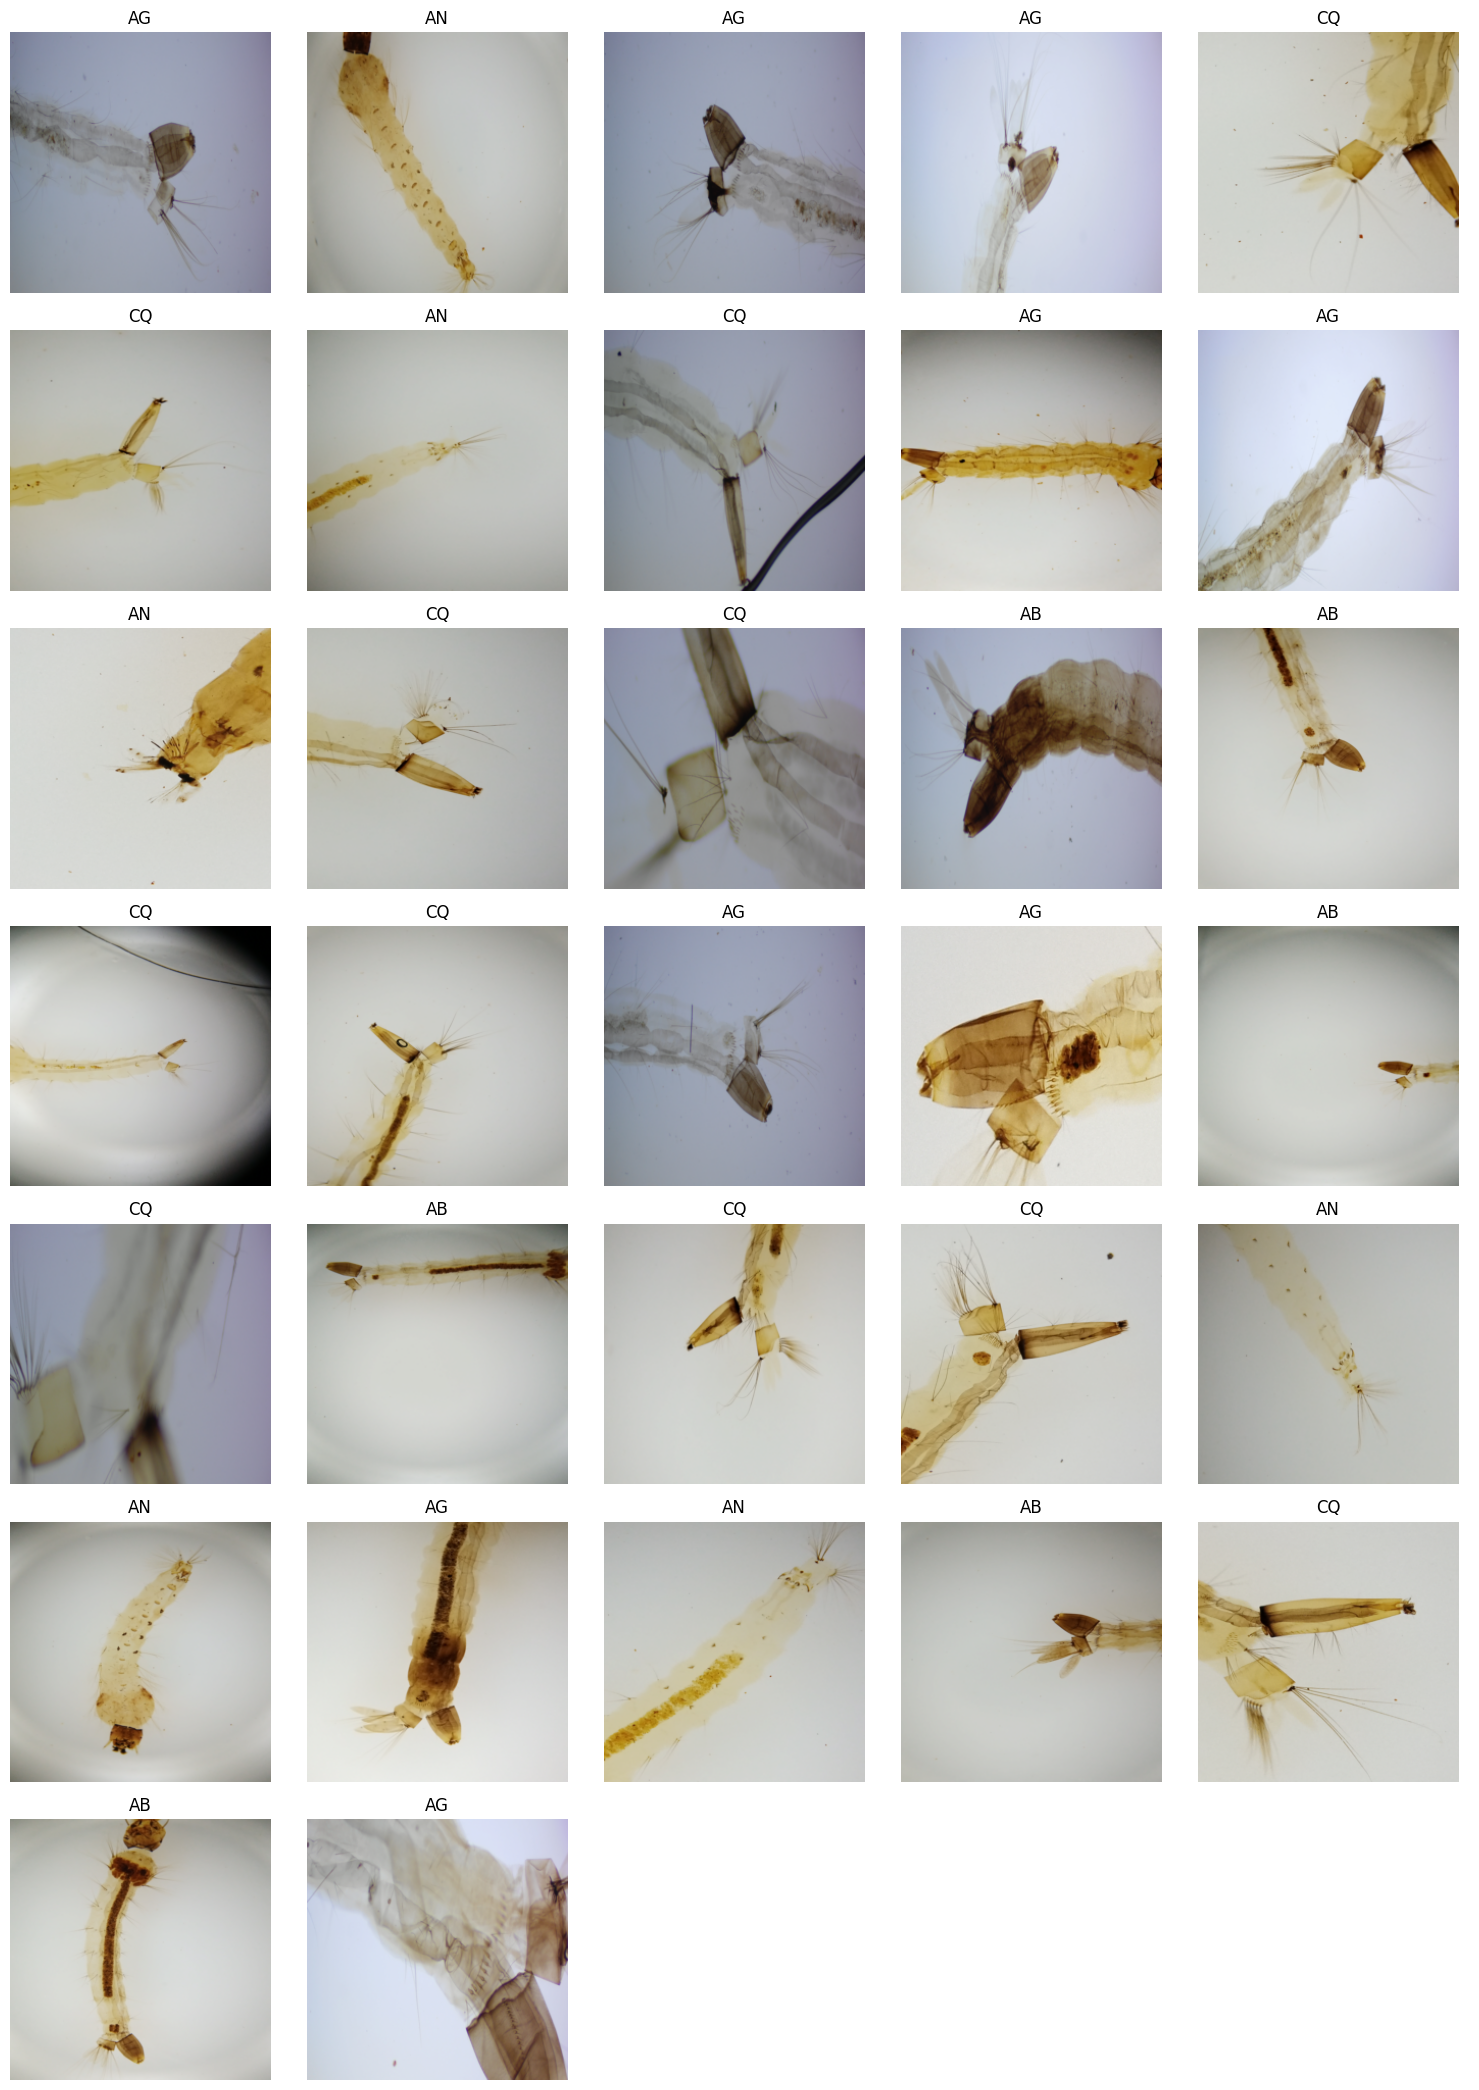

In [9]:
# ==============================
#  Display a random batch of balanced train dataset
# ==============================
images, labels = next(iter(train_loader))
show_images(images, labels, class_names)


/tmp/ipykernel_55/1724390546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="viridis")


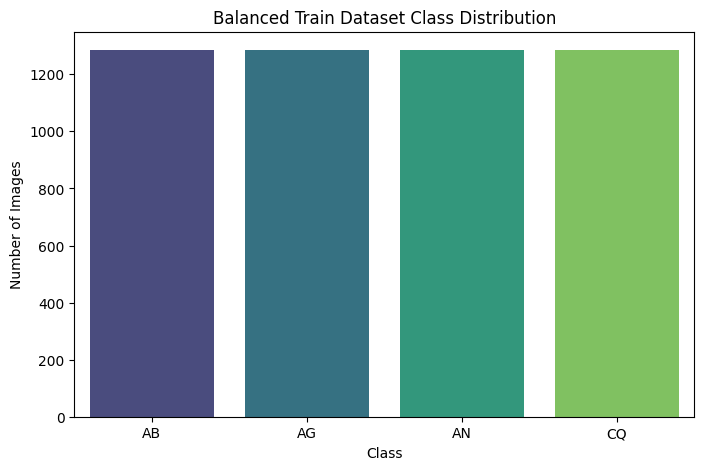

In [10]:
# ==============================
#  Plot class distribution in balanced train dataset
# ==============================
train_labels = [full_dataset.samples[i][1] for i in balanced_train_indices]
plt.figure(figsize=(8,5))
sns.countplot(x=train_labels, palette="viridis")
plt.title("Balanced Train Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

In [11]:
# ==============================
#  Model Definition
# ==============================
class CustomModel(nn.Module):
    def __init__(self, num_classes, hidden_sizes=[256, 128]):
        super(CustomModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=False)

        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Identity()

        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(num_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            num_features = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        features = self.mobilenet(x)
        output = self.classifier(features)
        return F.softmax(output, dim=1)

In [20]:
# ==============================
#  Device Setup
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
model = CustomModel(num_classes=num_classes).to(device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
from colorama import Fore

# ==============================
#  Training Setup
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
num_epochs = 10
from sklearn.metrics import precision_score, recall_score, f1_score

# ==============================
#  Training Loop
# ==============================
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for training data
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Phase
    model.eval()
    val_loss, val_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for validation data
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    # Test Phase (After each epoch or at the end of the training)
    model.eval()
    test_loss, test_corrects = 0.0, 0
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc.cpu().numpy())

    # Calculate precision, recall, and F1 score for test data
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

    # Print the metrics with different colors for Training, Validation, and Test
    print(f"{Fore.GREEN}Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f} | Train F1: {train_f1:.4f} | "
          f"{Fore.YELLOW}Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Precision: {val_precision:.4f} | "
          f"Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f} | "
          f"{Fore.RED}Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Precision: {test_precision:.4f} | "
          f"Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}{Fore.RESET}")

    scheduler.step()

Epoch [1/10] | Train Loss: 1.1226 | Train Acc: 0.6198 | Train Precision: 0.6140 | Train Recall: 0.6198 | Train F1: 0.6150 | Val Loss: 1.2611 | Val Acc: 0.4683 | Val Precision: 0.5753 | Val Recall: 0.4683 | Val F1: 0.4520 | Test Loss: 1.2726 | Test Acc: 0.4571 | Test Precision: 0.5689 | Test Recall: 0.4571 | Test F1: 0.4372
Epoch [2/10] | Train Loss: 1.0483 | Train Acc: 0.6920 | Train Precision: 0.6920 | Train Recall: 0.6920 | Train F1: 0.6913 | Val Loss: 1.0056 | Val Acc: 0.7319 | Val Precision: 0.7349 | Val Recall: 0.7319 | Val F1: 0.7272 | Test Loss: 1.0166 | Test Acc: 0.7250 | Test Precision: 0.7263 | Test Recall: 0.7250 | Test F1: 0.7206
Epoch [3/10] | Train Loss: 1.0208 | Train Acc: 0.7224 | Train Precision: 0.7227 | Train Recall: 0.7224 | Train F1: 0.7207 | Val Loss: 1.0264 | Val Acc: 0.7140 | Val Precision: 0.7582 | Val Recall: 0.7140 | Val F1: 0.7095 | Test Loss: 1.0577 | Test Acc: 0.6830 | Test Precision: 0.7415 | Test Recall: 0.6830 | Test F1: 0.6809
Epoch [4/10] | Train Loss

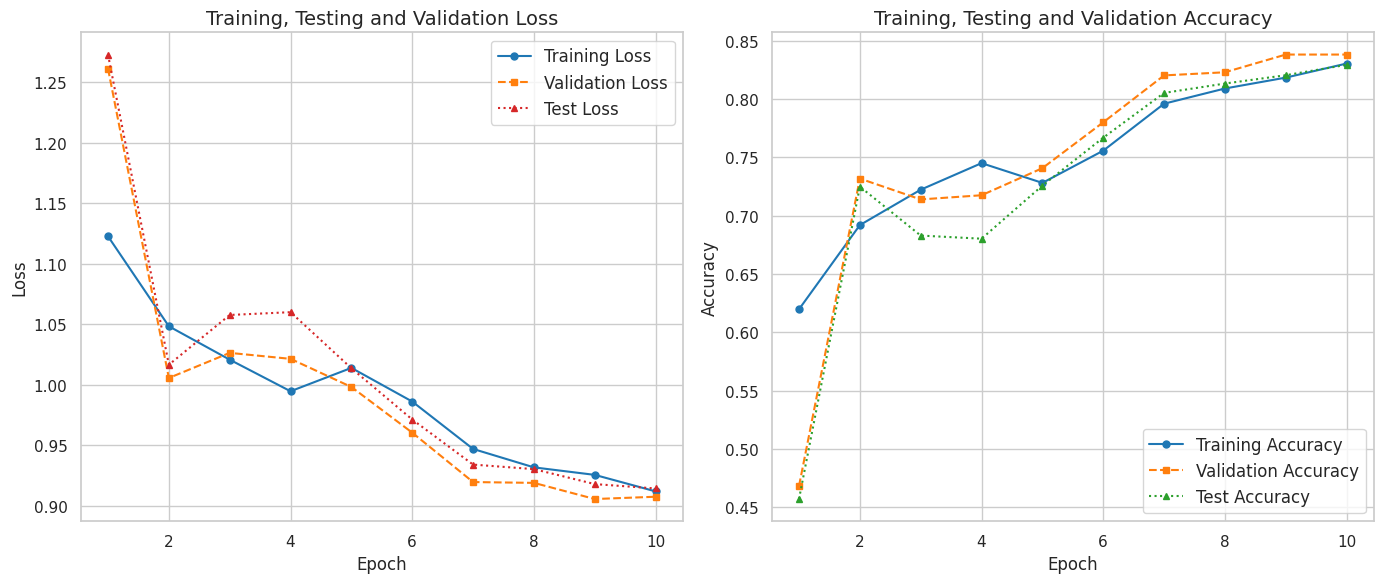

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots to make them visually appealing and suitable for Q1 standards
sns.set(style="whitegrid")

# ==============================
#  Plotting Accuracy and Loss
# ==============================
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, test_losses=None, test_accuracies=None):
    epochs = range(1, num_epochs + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(epochs, train_losses, label='Training Loss', color='tab:blue', marker='o', linestyle='-', markersize=5)
    plt.plot(epochs, val_losses, label='Validation Loss', color='tab:orange', marker='s', linestyle='--', markersize=5)
    if test_losses:
        plt.plot(epochs, test_losses, label='Test Loss', color='tab:red', marker='^', linestyle=':', markersize=5)  # Optional: Include test loss if available
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training, Testing and Validation Loss', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='tab:blue', marker='o', linestyle='-', markersize=5)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='tab:orange', marker='s', linestyle='--', markersize=5)
    if test_accuracies:
        plt.plot(epochs, test_accuracies, label='Test Accuracy', color='tab:green', marker='^', linestyle=':', markersize=5)  # Optional: Include test accuracy if available
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training, Testing and Validation Accuracy', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

# ==============================
#  After Training Loop
# ==============================
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, test_losses, test_accuracies)

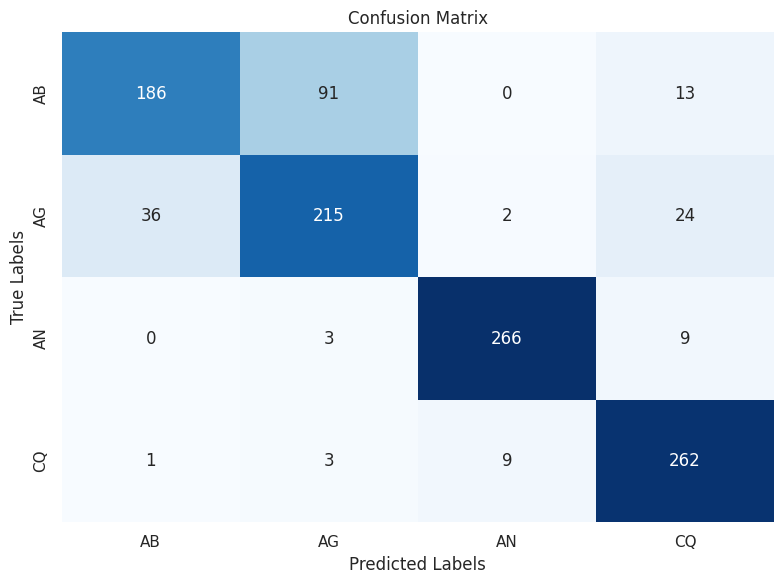

Confusion Matrix:
[[186  91   0  13]
 [ 36 215   2  24]
 [  0   3 266   9]
 [  1   3   9 262]]


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ==============================
#  Function to plot Confusion Matrix
# ==============================
def plot_confusion_matrix(true_labels, pred_labels, classes, fold):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(f"Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    # Optionally print the confusion matrix
    print(f"Confusion Matrix:")
    print(cm)

# ==============================
#  After Training Loop (or after each epoch)
# ==============================
# Assuming you have all the predicted and true labels from your test set:
all_test_preds = np.array(all_test_preds)  # Test predictions (from model)
all_test_labels = np.array(all_test_labels)  # Test true labels (from data)

# Define your class names for the 4 classes
class_names = ['AB', 'AG', 'AN', 'CQ']  # Replace with your actual class names

# Plot the confusion matrix for the test set (after the final epoch or after each epoch)
plot_confusion_matrix(all_test_labels, all_test_preds, class_names, fold=0)